# Simple implementation of RBM  in Pytorch by 刘毅

#  Import Some Libraries 

In [22]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

In [9]:
import torch.optim as optim
from torch.autograd import Variable

In [10]:
from torchvision import datasets ,transforms
from torchvision.utils import make_grid ,save_image

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

# Define a Show and Save Function

In [48]:
"this is plot and save function for the image"
def show_and_save(file_name,img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    plt.imshow(npimg)
    plt.imsave(f,npimg)

# Build the Boltzman Machine 

In [36]:
class RBM(nn.Module):
    def __init__(self,
                 n_vis=784,
                 n_hin=500,
                 k=5):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hin))
        self.k = k
    
    def sample_from_p(self,p):
        return F.relu(torch.sign(p - Variable(torch.rand(p.size()))))
    
    def v_to_h(self,v):
        p_h = F.sigmoid(F.linear(v,self.W,self.h_bias))
        sample_h = self.sample_from_p(p_h)
        return p_h,sample_h
    
    def h_to_v(self,h):
        p_v = F.sigmoid(F.linear(h,self.W.t(),self.v_bias))
        sample_v = self.sample_from_p(p_v)
        return p_v,sample_v
        
    def forward(self,v):
        pre_h1,h1 = self.v_to_h(v)
        
        h_ = h1
        for _ in range(self.k):
            pre_v_,v_ = self.h_to_v(h_)
            pre_h_,h_ = self.v_to_h(v_)
        
        return v,v_
    
    def free_energy(self,v):
        vbias_term = v.mv(self.v_bias)
        wx_b = F.linear(v,self.W,self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()

# Load dataset from mnist datasets

In [37]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=False,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size)

# SGD learn parameters 

In [38]:
rbm = RBM(k=1)
train_op = optim.SGD(rbm.parameters(),0.1)

for epoch in range(10):
    loss_=[]
    for _,(data,target) in enumerate(train_loader):
        data=Variable(data.view(-1,784))
        sample_data=data.bernoulli()
        
        v,v1 = rbm(sample_data)
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        loss_.append(loss.data[0])
        train_op.zero_grad()
        loss.backward()
        train_op.step()  
        
    print(np.mean(loss_))

-8.42617400928
-6.68504411579
-4.60668903017
-3.20309939517
-2.3059720688
-1.654058005
-1.16021364127
-0.712265079718
-0.532798685753
-0.350834502848


# Real Data

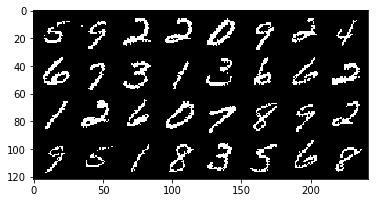

In [49]:
show_and_save("real",make_grid(v.view(32,1,28,28).data))

# Generative images

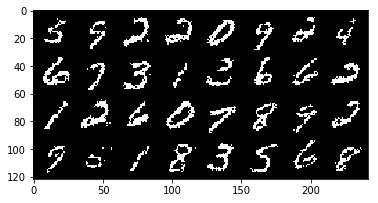

In [50]:
show_and_save("generate",make_grid(v1.view(32,1,28,28).data))